In [6]:
import pandas as pd
from ydata_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import random
import os
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
# sel_cols = ['CryoSleep','PairTravel','ServiceUsed',
#             'Transported','RoomService','Spa','VRDeck','set']

In [2]:
data = pd.read_csv('inputs/train.csv')
data['set'] = 'train'
# ProfileReport(data).to_file('outputs/train_report.html')
data.isna().sum()
test = pd.read_csv('inputs/test.csv')
test['set'] = 'test'

In [3]:
def fill_home_planet(row):
    if row['Deck'] in ['A','B','C']:
        return 'Europa'
    elif row['Deck'] in ['D']:
        return 'Mars'
    elif row['Deck'] in ['E','F','G']: # <------ 50% for E!
        return 'Earth'
    else:
        return 'Europa'
    
def fill_cryo_sleep(row):
    if row['ServiceUsed'] == 1:
        return 0
    else:
        return 1

def fill_deck(row):
    if row['HomePlanet']  == 'Europa':
        return random.choice(['A','B','C'])
    elif row['HomePlanet']  == 'Mars':
        return 'D'
    elif row['HomePlanet']  == 'Earth':
        return random.choice(['E','F','G'])
    else:
        return 'A'
    
def fill_vip(row):
    if row['TotalSpendings'] > 2000:
        return 1
    else:
        return 0


# Define the function to apply
def fill_spending_values(df, row, column):
    if pd.isna(row[column]):
        if row['VIP'] == True:
            return df.loc[df['VIP'] == True, column].median()
        else:
            return df.loc[df['VIP'] == False, column].median()
    else:
        return row[column]

In [4]:
df = pd.concat([data, test], axis=0)
""" Find paired passengers """
le = LabelEncoder()
passids = [x.split('_')[0] for x in df['PassengerId']]
pass_dict = {x: passids.count(x) for x in set(passids)}
df['PairTravel'] = df['PassengerId'].apply(lambda x: pass_dict[x.split('_')[0]] > 1)
df[['Deck','Room','Side']] = df['Cabin'].str.split('/', expand=True)
df['HomePlanet'] = df.apply(lambda x: fill_home_planet(x) if pd.isna(x['HomePlanet']) else x['HomePlanet'], axis=1)
df['ServiceUsed'] = df.apply(
    lambda x: True if x['RoomService'] >0 or x['FoodCourt'] >0 or x['ShoppingMall'] >0 or x['Spa'] >0 or x['VRDeck']> 0 else False,
      axis=1).astype(int)
df['CryoSleep'] = df.apply(lambda x: fill_cryo_sleep(x) if pd.isna(x['CryoSleep']) else x['CryoSleep'], axis=1)
df['Deck'] = df.apply(lambda x: fill_deck(x) if pd.isna(x['Deck']) else x['Deck'], axis=1)
df['TotalSpendings'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0).sum(axis=1)
df['VIP'] = df.apply(lambda x: fill_vip(x) if pd.isna(x['VIP']) else x['VIP'], axis=1)
df['RoomService'] = df.apply(lambda x: fill_spending_values(df, x, 'RoomService'), axis=1)
df['Spa'] = df.apply(lambda x: fill_spending_values(df, x, 'Spa'), axis=1)
df['VRDeck'] = df.apply(lambda x: fill_spending_values(df, x, 'VRDeck'), axis=1)

df['PairTravel'] = df['PairTravel'].astype(int)
df['CryoSleep'] = df['CryoSleep'].astype(int)
df['VIP'] = df['VIP'].astype(int)
df['ServiceUsed'] = df['ServiceUsed'].astype(int)
df['Transported'] = df['Transported'].apply(lambda x: int(x) if not pd.isna(x) else x)

df.head()
df.isna().sum()

PassengerId          0
HomePlanet           0
CryoSleep            0
Cabin              299
Destination        274
Age                270
VIP                  0
RoomService          0
FoodCourt          289
ShoppingMall       306
Spa                  0
VRDeck               0
Name               294
Transported       4277
set                  0
PairTravel           0
Deck                 0
Room               299
Side               299
ServiceUsed          0
TotalSpendings       0
dtype: int64

In [5]:
# df.apply(lambda x: x)

In [7]:
# model_data = df
# train_data = model_data[model_data['set'] == 'train']
# test_data = model_data[model_data['set'] == 'test']

In [10]:
df = df.drop(['PassengerId','Cabin','Side','set'], axis=1)

PassengerId          0
HomePlanet           0
CryoSleep            0
Cabin              299
Destination        274
Age                270
VIP                  0
RoomService          0
FoodCourt          289
ShoppingMall       306
Spa                  0
VRDeck               0
Name               294
Transported       4277
set                  0
PairTravel           0
Deck                 0
Room               299
Side               299
ServiceUsed          0
TotalSpendings       0
dtype: int64

In [8]:
train_data = train_data.drop('set', axis=1)
test_data = test_data.drop('set', axis=1)

In [17]:
df_val = train_data.sample(frac=0.1, random_state=666)
X_val, y_val = df_val.drop('Transported', axis=1), df_val['Transported']
X_val = torch.tensor(X_val.values).float()
y_val = torch.tensor(y_val.values).float()
torch.save(X_val, 'inputs/new_base/X_val.pt')
torch.save(y_val, 'inputs/new_base/y_val.pt')

df_train = train_data.drop(df_val.index)
X_train, y_train = df_train.drop('Transported', axis=1), df_train['Transported']
X_train = torch.tensor(X_train.values).float()
y_train = torch.tensor(y_train.values).float()
torch.save(X_train, 'inputs/new_base/X.pt')
torch.save(y_train, 'inputs/new_base/y.pt')
X_test = torch.tensor(test_data.drop('Transported', axis=1).values).float()
torch.save(X_test, 'inputs/new_base/X_test_kaggle.pt')

In [18]:
df = pd.concat([data, test], axis=0)
""" Find paired passengers """
le = LabelEncoder()
passids = [x.split('_')[0] for x in df['PassengerId']]
pass_dict = {x: passids.count(x) for x in set(passids)}
df['PairTravel'] = df['PassengerId'].apply(lambda x: pass_dict[x.split('_')[0]] > 1)
df[['Deck','Room','Side']] = df['Cabin'].str.split('/', expand=True)
df['HomePlanet'] = df.apply(lambda x: fill_home_planet(x) if pd.isna(x['HomePlanet']) else x['HomePlanet'], axis=1)
df['ServiceUsed'] = df.apply(
    lambda x: True if x['RoomService'] >0 or x['FoodCourt'] >0 or x['ShoppingMall'] >0 or x['Spa'] >0 or x['VRDeck']> 0 else False,
      axis=1).astype(int)
# df['CryoSleep'] = df.apply(lambda x: fill_cryo_sleep(x) if pd.isna(x['CryoSleep']) else x['CryoSleep'], axis=1)
# df['Deck'] = df.apply(lambda x: fill_deck(x) if pd.isna(x['Deck']) else x['Deck'], axis=1)
# df['TotalSpendings'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0).sum(axis=1)
# df['VIP'] = df.apply(lambda x: fill_vip(x) if pd.isna(x['VIP']) else x['VIP'], axis=1)
# df['RoomService'] = df.apply(lambda x: fill_spending_values(df, x, 'RoomService'), axis=1)
# df['Spa'] = df.apply(lambda x: fill_spending_values(df, x, 'Spa'), axis=1)
# df['VRDeck'] = df.apply(lambda x: fill_spending_values(df, x, 'VRDeck'), axis=1)

df['PairTravel'] = df['PairTravel'].astype(int)
df['CryoSleep'] = df['CryoSleep'].apply(lambda x: int(x) if not pd.isna(x) else np.nan)
df['VIP'] = df['VIP'].apply(lambda x: int(x) if not pd.isna(x) else np.nan)
df['ServiceUsed'] = df['ServiceUsed'].astype(int)
df['Transported'] = df['Transported'].apply(lambda x: int(x) if not pd.isna(x) else x)

df.head()
df.isna().sum()

PassengerId        0
HomePlanet         0
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
set                0
PairTravel         0
Deck             299
Room             299
Side             299
ServiceUsed        0
dtype: int64

In [19]:
dfna = df[['HomePlanet','Destination','CryoSleep','PairTravel','ServiceUsed','VIP','FoodCourt','ShoppingMall',
            'Transported','RoomService','Spa','VRDeck','set']]
le = LabelEncoder()
dfna['HomePlanet'] = le.fit_transform(dfna['HomePlanet'])
dfna['Destination'] = le.fit_transform(dfna['Destination']) #nan 3
dfna['Destination'] = dfna.Destination.apply(lambda x: np.nan if x == 3 else x)
dfna.reset_index(inplace=True)

df_not = dfna.drop(columns=['Transported','set'])
df_not.isna().sum()

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

imputer = KNNImputer(n_neighbors=50, weights="distance")
df_imputed = imputer.fit_transform(df_not)
df_imputed = pd.DataFrame(df_imputed, columns=df_not.columns)
df_imputed = df_imputed.astype(int)
df_imputed[['Transported','set']] = dfna[['Transported','set']]

# sc = StandardScaler()

# df_imputed = sc.fit_transform(df_imputed)


/tmp/ipykernel_18928/3299046608.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfna['HomePlanet'] = le.fit_transform(dfna['HomePlanet'])
/tmp/ipykernel_18928/3299046608.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfna['Destination'] = le.fit_transform(dfna['Destination']) #nan 3
/tmp/ipykernel_18928/3299046608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_12941/3227282883.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_nokaggle['labels'] = labels
/home/rmadeye/anaconda3/envs/data/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rmadeye/anaconda3/envs/data/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rmadeye/anaconda3/envs/data/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: 

<Axes: xlabel='0', ylabel='1'>

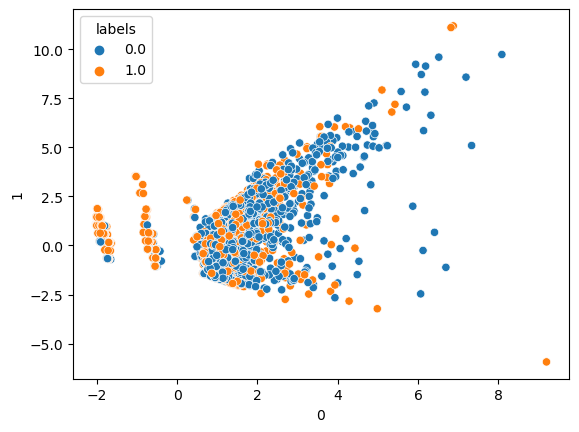

In [57]:
train = torch.load('/home/rmadeye/kaggle/spaceship/data/inputs/knnfill/X.pt')
val = torch.load('/home/rmadeye/kaggle/spaceship/data/inputs/knnfill/X_val.pt')
test = torch.load('/home/rmadeye/kaggle/spaceship/data/inputs/knnfill/X_test_kaggle.pt')

# make dataframes from tensors
df_train = pd.DataFrame(train.numpy())
df_train['source'] = 'train'
df_val = pd.DataFrame(val.numpy())
df_val['source'] = 'val'
df_test = pd.DataFrame(test.numpy())
df_test['source'] = 'test'
# merge all
df = pd.concat([df_train, df_val, df_test], ignore_index=True)
# MAKE PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=2)
sc = StandardScaler()
# df.columns = df.columns.astype(str)
X_main = df.iloc[:,:-1]
X_main
X_main = sc.fit_transform(X_main)  
X_pca = pca.fit(X_main)  
X_pca.explained_variance_ratio_
X_pca = pca.transform(X_main)   
X_pca = pd.DataFrame(X_pca)
X_pca.reset_index(inplace=True)
X_pca['source'] = df['source']
X_pca

labels = torch.concat([torch.load('/home/rmadeye/kaggle/spaceship/data/inputs/knnfill/y.pt'), torch.load('/home/rmadeye/kaggle/spaceship/data/inputs/knnfill/y_val.pt')], axis=0)
X_nokaggle  = X_pca.loc[X_pca['source'] != 'test']
X_nokaggle['labels'] = labels

X_nokaggle

sns.scatterplot(data=X_nokaggle, x=0, y=1, hue='labels')